The purpose of this note book is to apply the profit optiisation model to make predictions based on a set of met office data. This can then also be compared to Manon's results.

The code bellow imports the necessary python packages.

In [1]:
import sys
sys.path.append('../')

from src.vapour_pressure_deficit_calculation import vapour_pressure_deficit
from src.profit_optimisation_model import ProfitOptimisationModel, run_optimisation_model_on_data
from src.cumulative_Weibull_distribution_model import cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials
from src.hydraulic_cost_model import HydraulicCostModel
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.CO2_gain_model import CO2GainModel
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.photosynthesis_model import PhotosynthesisModel
from src.CO2_gain_model import CO2GainModel

from xarray import open_dataset
from pandas import DataFrame, date_range

from matplotlib import pyplot as plt

# Metoffice data

To run the model we need a set of environmental data, this we get from a netcdf file. The code bellow imports and prints a description of this file.

In [2]:
metoffice_data_file_address = "../../Example met data/Alice_Holt/data/UK-Ham_2002-2003_Met.nc"

metoffice_data_file = open_dataset(metoffice_data_file_address, decode_times = False)

print(metoffice_data_file)

<xarray.Dataset>
Dimensions:    (time: 17520, z: 1, y: 1, x: 1)
Coordinates:
  * time       (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
  * z          (z) float64 1.0
  * y          (y) float64 1.0
  * x          (x) float64 1.0
Data variables:
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
    SWdown     (time, y, x) float64 ...
    Tair       (time, y, x) float64 ...
    Precip     (time, y, x) float64 ...
    Qair       (time, y, x) float64 ...
    Wind       (time, y, x) float64 ...
    Psurf      (time, y, x) float64 ...
    LWdown     (time, y, x) float64 ...
    CO2air     (time, z, y, x) float64 ...
    za_tq      (y, x) float64 ...
    za_uv      (y, x) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com


We can take a closer look at the available data "columns" using the keys property.

In [3]:
print(metoffice_data_file.keys)

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:    (time: 17520, z: 1, y: 1, x: 1)
Coordinates:
  * time       (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
  * z          (z) float64 1.0
  * y          (y) float64 1.0
  * x          (x) float64 1.0
Data variables:
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
    SWdown     (time, y, x) float64 ...
    Tair       (time, y, x) float64 ...
    Precip     (time, y, x) float64 ...
    Qair       (time, y, x) float64 ...
    Wind       (time, y, x) float64 ...
    Psurf      (time, y, x) float64 ...
    LWdown     (time, y, x) float64 ...
    CO2air     (time, z, y, x) float64 ...
    za_tq      (y, x) float64 ...
    za_uv      (y, x) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com>


Alternativly you can inspect a netcdf file without the need to write python code. For example to view the header of the netcdf file from the terminal use the following command: 

$$ \text{ncdump -h file_address} $$

Note the -h restricts the output to only the header, if it is removed the entier file is printed. 

Alternativly for a graphical interface you can open the file using nasas panoply software (https://www.giss.nasa.gov/tools/panoply/download/).

From this file we only want a subset of the columns, specificaly air temperature, specific humidity, air pressure at the ground surface and the $CO_2$ fraction of the air. These columns are labeld Tair, Qair, Psurf and CO2air respectivly. The code bellow reduces the data to just these columns.

In [4]:
met_columns = ["Tair", "Qair", "Psurf", "CO2air"]
metoffice_data = metoffice_data_file[met_columns]

print(metoffice_data)

<xarray.Dataset>
Dimensions:  (time: 17520, y: 1, x: 1, z: 1)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
  * z        (z) float64 1.0
  * y        (y) float64 1.0
  * x        (x) float64 1.0
Data variables:
    Tair     (time, y, x) float64 ...
    Qair     (time, y, x) float64 ...
    Psurf    (time, y, x) float64 ...
    CO2air   (time, z, y, x) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com


We can see that each column is actualy three dimentional. The first dimension coressponds to the time at wich the measurment is conducted. The remaining two dimentions "x" and "y" are needed when running simulations over a grid of adjacent sites, and "z" is used to brake the atmospher into different cells. The data in this particular file only uses one site and a single hight cell so we can remove these three diemtions.

In [5]:
metoffice_data = metoffice_data.squeeze(dim=["x", "y", "z"], drop = True)

print(metoffice_data)

<xarray.Dataset>
Dimensions:  (time: 17520)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
Data variables:
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    Psurf    (time) float64 ...
    CO2air   (time) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com


Next we convert this into a pandas data frame to make it easier to work with.

In [6]:
metoffice_data = metoffice_data.to_pandas()

print(metoffice_data)

               Tair      Qair     Psurf  CO2air
time                                           
0.0         289.322  0.006778  101608.0  418.56
1800.0      289.322  0.006778  101608.0  418.56
3600.0      287.886  0.006796  101628.0  418.56
5400.0      287.886  0.006796  101628.0  418.56
7200.0      286.193  0.006731  101659.0  418.56
...             ...       ...       ...     ...
31527000.0  285.735  0.006571   99948.7  418.56
31528800.0  286.414  0.006736   99905.7  418.56
31530600.0  286.414  0.006736   99905.7  418.56
31532400.0  285.521  0.007251   99803.2  418.56
31534200.0  285.521  0.007251   99803.2  418.56

[17520 rows x 4 columns]


Inorder to run the profit optimisation model we need the vapour pressure deficit in $kPa$.

In [7]:
metoffice_data['VPD'] = vapour_pressure_deficit(metoffice_data['Tair'],
                                                metoffice_data['Qair'],
                                                metoffice_data['Psurf'])

print(metoffice_data)

               Tair      Qair     Psurf  CO2air       VPD
time                                                     
0.0         289.322  0.006778  101608.0  418.56  0.734297
1800.0      289.322  0.006778  101608.0  418.56  0.734297
3600.0      287.886  0.006796  101628.0  418.56  0.569528
5400.0      287.886  0.006796  101628.0  418.56  0.569528
7200.0      286.193  0.006731  101659.0  418.56  0.405156
...             ...       ...       ...     ...       ...
31527000.0  285.735  0.006571   99948.7  418.56  0.404794
31528800.0  286.414  0.006736   99905.7  418.56  0.445145
31530600.0  286.414  0.006736   99905.7  418.56  0.445145
31532400.0  285.521  0.007251   99803.2  418.56  0.277809
31534200.0  285.521  0.007251   99803.2  418.56  0.277809

[17520 rows x 5 columns]


The time column here is not in the format we necesseraly want so lets create another column with the date and time of each measurement.

In [8]:
units, reference_date = metoffice_data_file.time.attrs['units'].split('since')

start = reference_date.strip()[0:19].replace("-","/")

metoffice_data['date time'] = date_range(start = start, periods = len(metoffice_data), freq = '30MIN')

print(metoffice_data)

               Tair      Qair     Psurf  CO2air       VPD           date time
time                                                                         
0.0         289.322  0.006778  101608.0  418.56  0.734297 2022-01-01 00:00:00
1800.0      289.322  0.006778  101608.0  418.56  0.734297 2022-01-01 00:30:00
3600.0      287.886  0.006796  101628.0  418.56  0.569528 2022-01-01 01:00:00
5400.0      287.886  0.006796  101628.0  418.56  0.569528 2022-01-01 01:30:00
7200.0      286.193  0.006731  101659.0  418.56  0.405156 2022-01-01 02:00:00
...             ...       ...       ...     ...       ...                 ...
31527000.0  285.735  0.006571   99948.7  418.56  0.404794 2022-12-31 21:30:00
31528800.0  286.414  0.006736   99905.7  418.56  0.445145 2022-12-31 22:00:00
31530600.0  286.414  0.006736   99905.7  418.56  0.445145 2022-12-31 22:30:00
31532400.0  285.521  0.007251   99803.2  418.56  0.277809 2022-12-31 23:00:00
31534200.0  285.521  0.007251   99803.2  418.56  0.277809 2022-1

## Missing model inputs

The data available within the file doesn't contain the soil water potential or intercellular oxygen concentration so for now we set these values. The code used later takes these values in as an array of the same size as time steps so we need to create one for each and add it to the pandas data frame.

In [9]:
soil_water_potential = -0.0 # MPa
intercellular_oxygen = 210.0 #(umol mol-1)

metoffice_data['soil water potential'] = soil_water_potential
metoffice_data['intercellular oxygen'] = intercellular_oxygen

print(metoffice_data)

               Tair      Qair     Psurf  CO2air       VPD           date time  \
time                                                                            
0.0         289.322  0.006778  101608.0  418.56  0.734297 2022-01-01 00:00:00   
1800.0      289.322  0.006778  101608.0  418.56  0.734297 2022-01-01 00:30:00   
3600.0      287.886  0.006796  101628.0  418.56  0.569528 2022-01-01 01:00:00   
5400.0      287.886  0.006796  101628.0  418.56  0.569528 2022-01-01 01:30:00   
7200.0      286.193  0.006731  101659.0  418.56  0.405156 2022-01-01 02:00:00   
...             ...       ...       ...     ...       ...                 ...   
31527000.0  285.735  0.006571   99948.7  418.56  0.404794 2022-12-31 21:30:00   
31528800.0  286.414  0.006736   99905.7  418.56  0.445145 2022-12-31 22:00:00   
31530600.0  286.414  0.006736   99905.7  418.56  0.445145 2022-12-31 22:30:00   
31532400.0  285.521  0.007251   99803.2  418.56  0.277809 2022-12-31 23:00:00   
31534200.0  285.521  0.00725

## Resampling the data

Currently the met data we are working with contains a years worth of measurments seperated byhalf an hour totaling $17520$ entries. To reduce the computation time we will reduce the data to be every six hours (reducing the data to $1460$ entries).

In [10]:
current_time_step = 0.5 #h
target_time_step = 6 #h

resample_step = int(target_time_step / current_time_step)
print("resample step: ", resample_step, "\n")

metoffice_data = metoffice_data.iloc[::resample_step, :]

print(metoffice_data)

resample step:  12 

               Tair      Qair     Psurf  CO2air       VPD           date time  \
time                                                                            
0.0         289.322  0.006778  101608.0  418.56  0.734297 2022-01-01 00:00:00   
21600.0     284.987  0.006884  101766.0  418.56  0.264953 2022-01-01 06:00:00   
43200.0     287.113  0.007292  102050.0  418.56  0.402458 2022-01-01 12:00:00   
64800.0     285.714  0.007400  102289.0  418.56  0.243053 2022-01-01 18:00:00   
86400.0     289.322  0.006778  101608.0  418.56  0.734297 2022-01-02 00:00:00   
...             ...       ...       ...     ...       ...                 ...   
31428000.0  287.884  0.007442   98383.9  418.56  0.503225 2022-12-30 18:00:00   
31449600.0  287.105  0.007443   99775.5  418.56  0.404153 2022-12-31 00:00:00   
31471200.0  287.168  0.007439   99423.2  418.56  0.415499 2022-12-31 06:00:00   
31492800.0  285.686  0.006994   98671.7  418.56  0.347002 2022-12-31 12:00:00   
3151440

# Applying the model

Now that we have the necessary data the next step is to creat the model.

In [11]:
hydraulic_conductance_model = \
    cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials(maximum_conductance = 1, # mmol m-2 s-1 MPa-1
                                                                                    water_potential_1 = -6.6, # MPa
                                                                                    water_potential_2 = -10.5, # MPa
                                                                                    conductance_loss_fraction_1 = 0.5,
                                                                                    conductance_loss_fraction_2 = 0.88)

critical_leaf_water_potential = hydraulic_conductance_model.water_potential_from_conductivity_loss_fraction(0.95)

hydraulic_cost_model = HydraulicCostModel(hydraulic_conductance_model = hydraulic_conductance_model,
                                          saturated_water_potential = soil_water_potential,
                                          critical_leaf_water_potential = critical_leaf_water_potential)

leaf_air_coupling_model = LeafAirCouplingModel()
photosynthesis_model = PhotosynthesisModel()

CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

profit_optimisation_model = ProfitOptimisationModel(hydraulic_cost_model,
                                                    leaf_air_coupling_model,
                                                    CO2_gain_model)

We can now apply the model to calculate the optimal leaf water potential along with the net CO2 uptake and transpiration rate.

In [12]:

model_results = metoffice_data.copy()

model_results['leaf water potential'], model_results['net CO2 uptake'], model_results['transpiration rates'] = \
    run_optimisation_model_on_data(profit_optimisation_model,
                                   time_steps = model_results['date time'].to_numpy(),
                                   soil_water_potential_values = model_results['soil water potential'].to_numpy(),
                                   air_temperature_values = model_results['Tair'].to_numpy(),
                                   air_vapour_pressure_deficit_values = model_results['VPD'].to_numpy(),
                                   air_pressure_values = model_results['Psurf'].to_numpy(),
                                   atmospheric_CO2_concentration_values = model_results['CO2air'].to_numpy(),
                                   intercellular_oxygen_values = model_results['intercellular oxygen'].to_numpy(),
                                   number_of_leaf_water_potential_sample_points = 1000)

# Plotting the ressults

Having applied the model to the met data we can plot how the results change over the year.

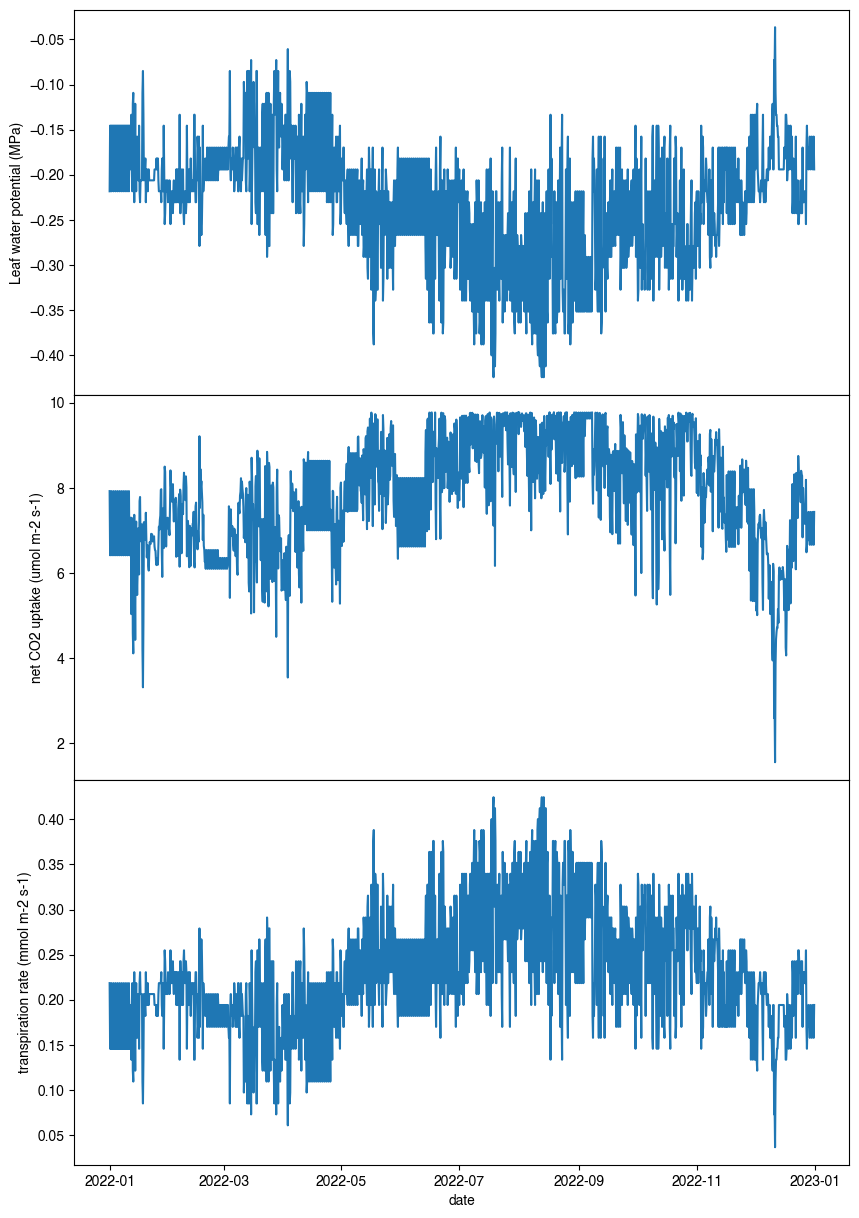

In [13]:
fig, axis = plt.subplots(3, sharex=True)

# Plot the data
axis[0].plot(model_results['date time'].to_numpy(), model_results['leaf water potential'].to_numpy())
axis[1].plot(model_results['date time'].to_numpy(), model_results['net CO2 uptake'].to_numpy())
axis[2].plot(model_results['date time'].to_numpy(), model_results['transpiration rates'].to_numpy())

# Add labels
axis[0].set_ylabel("Leaf water potential (MPa)")
axis[1].set_ylabel("net CO2 uptake (umol m-2 s-1)")
axis[2].set_ylabel("transpiration rate (mmol m-2 s-1)")
axis[2].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

There is a lot of noise in these plots, this is due to us ploting the results at four different times of day (00:00, 06:00, 12:00 and 18:00). To solve this problem let us split the data into the four different times of day.

In [14]:
model_results_midnight = model_results.iloc[0::4]
model_results_six_am = model_results.iloc[1::4]
model_results_midday = model_results.iloc[2::4]
model_results_six_pm = model_results.iloc[3::4]

print(model_results_midday)

               Tair      Qair     Psurf  CO2air       VPD           date time  \
time                                                                            
43200.0     287.113  0.007292  102050.0  418.56  0.402458 2022-01-01 12:00:00   
129600.0    287.113  0.007292  102050.0  418.56  0.402458 2022-01-02 12:00:00   
216000.0    287.113  0.007292  102050.0  418.56  0.402458 2022-01-03 12:00:00   
302400.0    287.113  0.007292  102050.0  418.56  0.402458 2022-01-04 12:00:00   
388800.0    287.113  0.007292  102050.0  418.56  0.402458 2022-01-05 12:00:00   
...             ...       ...       ...     ...       ...                 ...   
31147200.0  290.130  0.005770  100938.0  418.56  1.000749 2022-12-27 12:00:00   
31233600.0  285.983  0.006968   98792.1  418.56  0.378298 2022-12-28 12:00:00   
31320000.0  285.686  0.006994   98671.7  418.56  0.347002 2022-12-29 12:00:00   
31406400.0  285.686  0.006994   98671.7  418.56  0.347002 2022-12-30 12:00:00   
31492800.0  285.686  0.00699

Bellow we plot the model results for midday and six am. We explicitly choose to plot midday as this corresponds to the point when the sun is strongest. Six am is chosen as a rough proxy for pre-dwan as the tree is expected to equilibriate with the soil water potential over night.

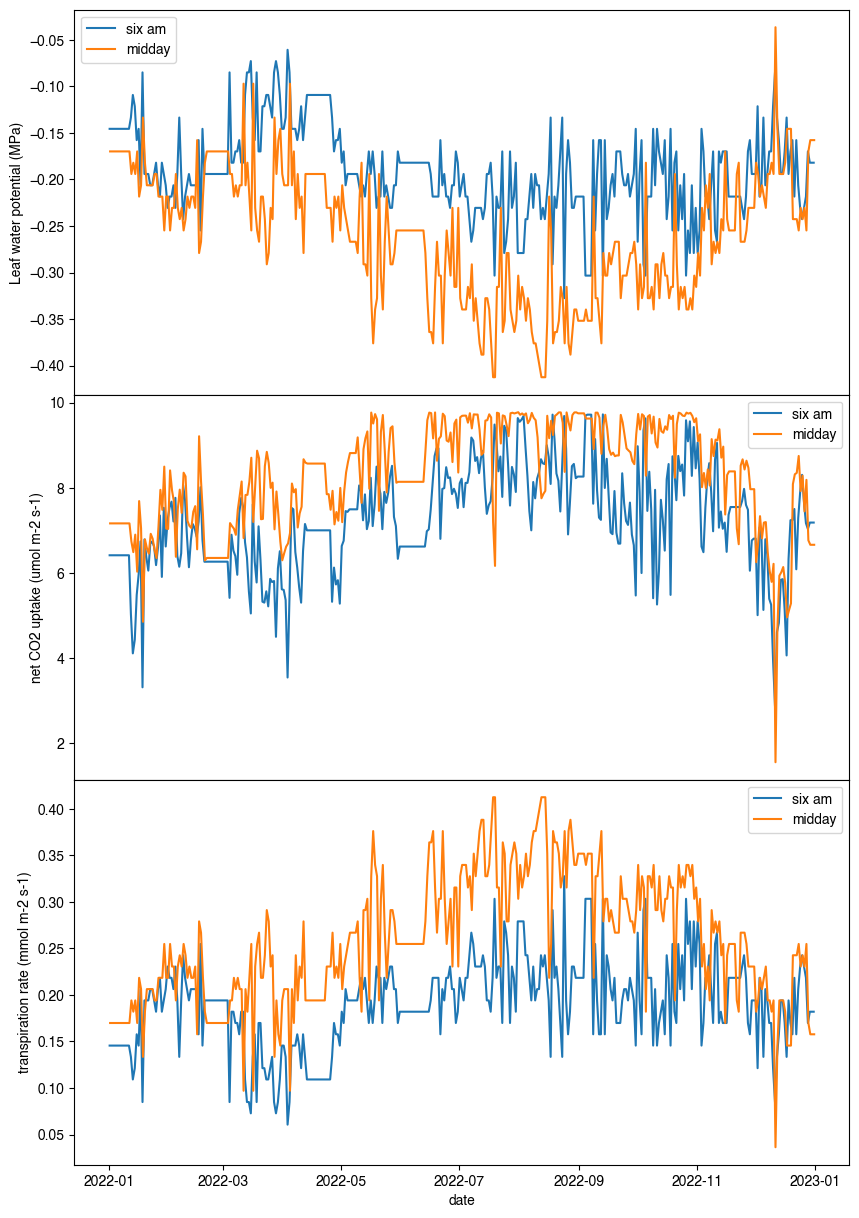

In [15]:
fig, axis = plt.subplots(3, sharex=True)

# Plot the leaf water potential
axis[0].plot(model_results_six_am['date time'].to_numpy()  , model_results_six_am['leaf water potential'].to_numpy()  , label = 'six am')
#axis[0].plot(model_results_six_pm['date time'].to_numpy()  , model_results_six_pm['leaf water potential'].to_numpy()  , label = 'six pm')
#axis[0].plot(model_results_midnight['date time'].to_numpy(), model_results_midnight['leaf water potential'].to_numpy(), label = 'midnight')
axis[0].plot(model_results_midday['date time'].to_numpy()  , model_results_midday['leaf water potential'].to_numpy()  , label = 'midday')
axis[0].legend()

# Plot the net CO2 uptake
axis[1].plot(model_results_six_am['date time'].to_numpy()  , model_results_six_am['net CO2 uptake'].to_numpy()  , label = 'six am')
#axis[1].plot(model_results_six_pm['date time'].to_numpy()  , model_results_six_pm['net CO2 uptake'].to_numpy()  , label = 'six pm')
#axis[1].plot(model_results_midnight['date time'].to_numpy(), model_results_midnight['net CO2 uptake'].to_numpy(), label = 'midnight')
axis[1].plot(model_results_midday['date time'].to_numpy()  , model_results_midday['net CO2 uptake'].to_numpy()  , label = 'midday')
axis[1].legend()

# Plot the transpiration rate
axis[2].plot(model_results_six_am['date time'].to_numpy()  , model_results_six_am['transpiration rates'].to_numpy()  , label = 'six am')
#axis[2].plot(model_results_six_pm['date time'].to_numpy()  , model_results_six_pm['transpiration rates'].to_numpy()  , label = 'six pm')
#axis[2].plot(model_results_midnight['date time'].to_numpy(), model_results_midnight['transpiration rates'].to_numpy(), label = 'midnight')
axis[2].plot(model_results_midday['date time'].to_numpy()  , model_results_midday['transpiration rates'].to_numpy()  , label = 'midday')
axis[2].legend()

# Add labels
axis[0].set_ylabel("Leaf water potential (MPa)")
axis[1].set_ylabel("net CO2 uptake (umol m-2 s-1)")
axis[2].set_ylabel("transpiration rate (mmol m-2 s-1)")
axis[2].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

# Comparing results

Now we can compare the results of running the model above to those from JULES and CABLE along with real observations. To achive this we need to first load and reformat the results files as we did for the metoffice data.

In [ ]:
metoffice_data_file_address = "../../Example met data/Alice_Holt/data/UK-Ham_2002-2003_Met.nc"